In [ ]:
pip install gseapy==1.0.4


In [1]:

import gseapy as gp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [3]:
gene_list_nr1d1 = pd.read_csv("nr1d1_uniq_ID.txt",header=0, sep="\t")

# if you are nly intrested in dataframe that enrichr returned, please set outdir=None
enr_nr1d1 = gp.enrichr(gene_list=gene_list_nr1d1, 
                 gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2021', 'MGI_Mammalian_Phenotype_Level_4', 'KEGG_2021_Mouse'],
                 organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

2024-07-26 11:14:10,470 [WARNING] Input library not found: KEGG_2021_Mouse. Skip


In [4]:

gene_list_hdac3 = pd.read_csv("hdac3_uniq_ID.txt",header=0, sep="\t")
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr_hdac3 = gp.enrichr(gene_list=gene_list_hdac3, 
                 gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2021', 'MGI_Mammalian_Phenotype_Level_4'],
                 organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [5]:
gene_list_nfil3 = pd.read_csv("nfil3_uniq_ID.txt",header=0, sep="\t")
enr_nfil3 = gp.enrichr(gene_list=gene_list_nfil3, 
                 gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2021', 'MGI_Mammalian_Phenotype_Level_4'],
                 organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [6]:
enr_hdac3.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,p53 Pathway,15/200,0.001073,0.053662,0,0,2.663202,18.208529,BTG1;SPHK1;LIF;RPS27L;HINT1;CCND2;TCN2;FAM162A...
1,MSigDB_Hallmark_2020,Inflammatory Response,14/200,0.002943,0.073581,0,0,2.467944,14.383769,MSR1;FZD5;CSF1;CCL20;SPHK1;LIF;NMI;OSMR;EREG;R...
2,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,13/200,0.007526,0.125431,0,0,2.275406,11.125384,BTG1;CSF1;CCL20;SPHK1;LIF;CFLAR;NFKB2;NINJ1;TN...
3,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,12/199,0.017259,0.127715,0,0,2.096802,8.511816,SPRED2;NT5E;CCND2;BMPR2;CSF1;P4HA1;CCNE1;PUS1;...
4,MSigDB_Hallmark_2020,Glycolysis,12/200,0.017880,0.127715,0,0,2.085541,8.392347,GYS1;LDHA;NT5E;GAL3ST1;P4HA1;FAM162A;DDIT4;RRA...


In [7]:
enr_nr1d1_results = enr_nr1d1.results
enr_hdac3_results = enr_hdac3.results
enr_nfil3_results = enr_nfil3.results

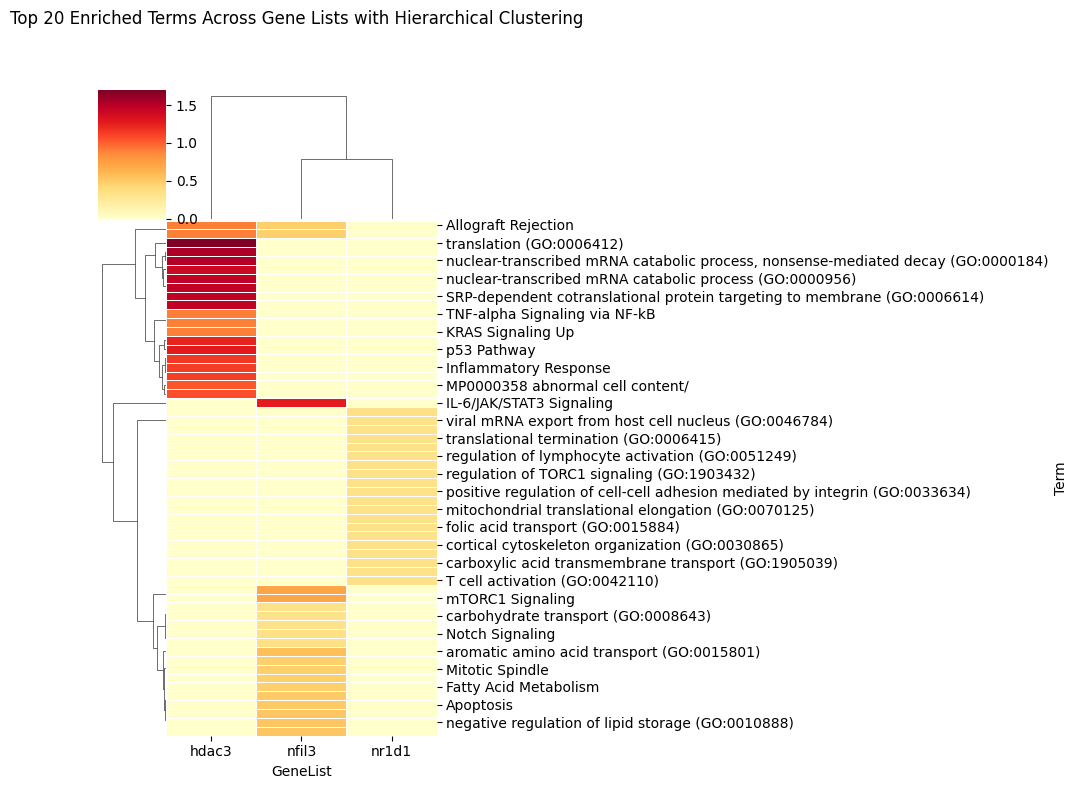

In [8]:

from scipy.cluster.hierarchy import dendrogram, linkage
# Combine the top terms into one DataFrame

# select top 20 terms
top_nr1d1_terms = enr_nr1d1_results.nsmallest(20, 'Adjusted P-value')
top_hdac3_terms = enr_hdac3_results.nsmallest(20, 'Adjusted P-value')
top_nfil3_terms = enr_nfil3_results.nsmallest(20, 'Adjusted P-value')

top_nr1d1_terms['GeneList'] = 'nr1d1'
top_hdac3_terms['GeneList'] = 'hdac3'
top_nfil3_terms['GeneList'] = 'nfil3'
combined_results = pd.concat([top_nr1d1_terms, top_hdac3_terms, top_nfil3_terms])

# Remove duplicates if necessary
combined_results = combined_results.drop_duplicates(subset=['Term', 'GeneList'])

combined_results['Adjusted P-value'] = combined_results['Adjusted P-value'].replace(0, 1e-300)

# Pivot the combined DataFrame to create a matrix for the heatmap
heatmap_data = combined_results.pivot(index='Term', columns='GeneList', values='Adjusted P-value')

# Fill NaN values with 1 before log transformation, indicating no enrichment
heatmap_data = heatmap_data.fillna(1)

# Convert the p-values to -log10(p-value) for visualization
# This will now not result in infinite values because there are no zeros
heatmap_data_log = -np.log10(heatmap_data)

row_linkage = linkage(heatmap_data_log, method='average')
col_linkage = linkage(heatmap_data_log.T, method='average')

# Create the clustermap with seaborn
clustergrid = sns.clustermap(heatmap_data_log, row_linkage=row_linkage, col_linkage=col_linkage,
                             cmap='YlOrRd', annot=None, linewidths=.5, figsize=(10, 8))

# Set the title with a horizontal position using `set_title`
clustergrid.fig.suptitle('Top 20 Enriched Terms Across Gene Lists with Hierarchical Clustering', 
                         ha='right')  # `ha` is short for horizontalalignment

# Adjust the position of the main plot to make space for the title
plt.subplots_adjust(top=0.88)

# Show the plot
plt.show()

C:\Users\xueke\AppData\Local\Temp\ipykernel_27384\1304874198.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Scaled Combined Score')


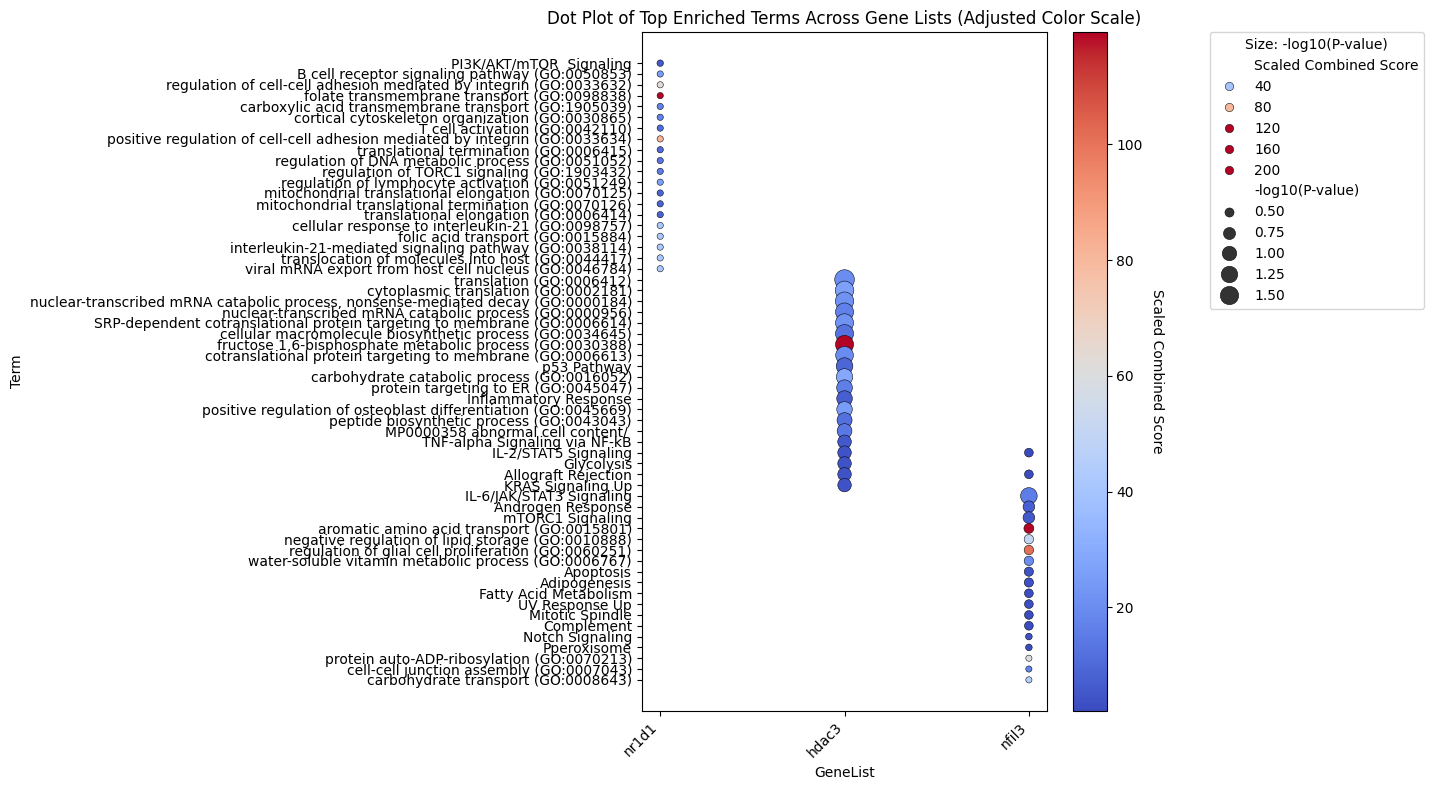

In [24]:
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_results is already defined and contains the necessary data

# Scale down the Combined Score by a desired factor
scaling_factor = 2  # Adjust this factor as needed
combined_results['Scaled Combined Score'] = combined_results['Combined Score'] / scaling_factor

# Set a specific range for hue normalization
min_color_value = combined_results['Scaled Combined Score'].min()
max_color_value = combined_results['Scaled Combined Score'].max() * 0.5

# Create the dot plot with scaled scores
plt.figure(figsize=(14, 8))  # Increase the figure size for better layout
dotplot = sns.scatterplot(data=combined_results, x='GeneList', y='Term',
                          size='-log10(P-value)', hue='Scaled Combined Score',
                          palette='coolwarm', edgecolor='black', sizes=(20, 200),
                          hue_norm=(min_color_value, max_color_value))

# Customize the color bar
norm = plt.Normalize(min_color_value, max_color_value)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Scaled Combined Score')
cbar.set_label('Scaled Combined Score', rotation=270, labelpad=15)

# Adjust legend position
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0., title='Size: -log10(P-value)')

# Adjust layout to avoid overlap
plt.subplots_adjust(left=0.5, right=0.6, top=0.9, bottom=0.1)  # Adjust these values as needed
plt.xticks(rotation=45, ha='right')
plt.title('Dot Plot of Top Enriched Terms Across Gene Lists (Adjusted Color Scale)')
plt.tight_layout()

# Show the plot
plt.show()


Combined Score is derived using a combination of the p-value and the odds ratio, reflecting both the significance and the magnitude of enrichment. Here’s a common formula used in tools like Enrichr:
Combined Score = Odds Ratio × −log⁡10(p-value)
Odds Ratio: This measures the odds of a gene set being enriched in the input list compared to what would be expected by chance. A higher odds ratio indicates a stronger enrichment.
p-value: This is a statistical measure that indicates the probability of observing the given enrichment by chance. A lower p-value indicates higher statistical significance.

In [26]:
combined_results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,GeneList,-log10(P-value),Normalized Combined Score,Scaled Combined Score
0,MSigDB_Hallmark_2020,PI3K/AKT/mTOR Signaling,10/105,0.009356,0.458442,0,0,2.545636,11.892553,MAPK9;TBK1;PPP2R1B;CAB39L;LCK;PRKAR2A;MKNK1;IT...,nr1d1,0.338715,0.016009,5.946277
49,GO_Biological_Process_2021,B cell receptor signaling pathway (GO:0050853),7/34,0.000333,0.468449,0,0,6.268320,50.184016,ITK;SYK;LCK;NFAM1;BLNK;PIK3CD;CD38,nr1d1,0.329338,0.096961,25.092008
50,GO_Biological_Process_2021,regulation of cell-cell adhesion mediated by i...,4/10,0.000440,0.468449,0,0,16.075377,124.249186,DPP4;CCL5;CD3E;SKAP1,nr1d1,0.329338,0.253543,62.124593
51,GO_Biological_Process_2021,folate transmembrane transport (GO:0098838),3/5,0.000600,0.468449,0,0,36.131744,268.036371,ABCC5;SLC25A32;SLC19A1,nr1d1,0.329338,0.557526,134.018186
52,GO_Biological_Process_2021,carboxylic acid transmembrane transport (GO:19...,7/41,0.001093,0.468449,0,0,4.975966,33.929773,SLC16A1;ABCC5;SLC6A14;SLC38A7;SLC38A10;SLC19A1...,nr1d1,0.329338,0.062598,16.964887


Identify the Regulating Genes or TFs:
This step involves determining which genes or TFs are associated with the regulation of each term or pathway. This can be done using databases like TRANSFAC, JASPAR, or through literature review. The identified genes/TFs should be linked to the pathways they regulate.

Perform Enrichment Analysis:
For each set of genes regulated by the same TF, perform enrichment analysis for the conditions (e.g., hdac3, nfil3, nr1d1). Tools like GSEA, Enrichr, or clusterProfiler in R can be used for this purpose. Calculate an enrichment score, such as -log10(p-value) or a combined score, for each pathway-condition pair.

Create the Matrix and Visualize:
Once you have the enrichment data, structure it into a matrix format where rows represent the TFs or regulating genes, columns represent the conditions, and cells contain the enrichment scores. Finally, visualize this matrix using a heatmap.

In [35]:
import pandas as pd

# Load TRRUST database
trrust_path = 'trrust_rawdata.mouse.tsv'
trrust_df = pd.read_csv(trrust_path, sep='\t', header=None, names=['TF', 'Target', 'Mode', 'PMID'])

# Display the first few rows to understand the structure
trrust_df.head()


,TF,Target,Mode,PMID
0,Aatf,Bak1,Unknown,22983126
1,Aatf,Bax,Unknown,22983126
2,Aatf,Bbc3,Unknown,22983126
3,Aatf,Cdkn1a,Unknown,21317046
4,Aatf,Tpt1,Activation,17157788


In [36]:
# Load gene lists
nfil3_genes_path = 'nfil3_uniq_ID.txt'
nr1d1_genes_path = 'nr1d1_uniq_ID.txt'
hdac3_genes_path = 'hdac3_uniq_ID.txt'
# Display the first few lines to check the structure and column names
nfil3_df = pd.read_csv(nfil3_genes_path, sep='\t')
nr1d1_df = pd.read_csv(nr1d1_genes_path, sep='\t')
hdac3_df = pd.read_csv(hdac3_genes_path, sep='\t')
# Determine the actual column names to use for gene IDs
# For demonstration, we'll assume the first column contains gene IDs
nfil3_genes = nfil3_df.iloc[:, 0].tolist()
nr1d1_genes = nr1d1_df.iloc[:, 0].tolist()
hdac3_genes = hdac3_df.iloc[:, 0].tolist()

# Combine gene lists into a dictionary
gene_lists = {
    'nfil3': nfil3_genes,
    'nr1d1': nr1d1_genes,
    'hdac3': hdac3_genes
}

# Identify TFs regulating these genes
regulated_genes = {}

for gene_list_name, genes in gene_lists.items():
    # Find TFs that regulate these genes
    regulated_genes[gene_list_name] = trrust_df[trrust_df['Target'].isin(genes)]['TF'].unique().tolist()

# Display the TFs regulating the genes in each list
for key, value in regulated_genes.items():
    print(f"TFs regulating genes in {key}: {value}")

# Create a matrix showing TFs and their regulated genes for each condition
tf_gene_matrix = {tf: {gene_list: 0 for gene_list in gene_lists.keys()} for tf in trrust_df['TF'].unique()}

for gene_list_name, genes in gene_lists.items():
    for gene in genes:
        regulated_tfs = trrust_df[trrust_df['Target'] == gene]['TF'].tolist()
        for tf in regulated_tfs:
            if tf in tf_gene_matrix:
                tf_gene_matrix[tf][gene_list_name] += 1

# Convert to DataFrame for easier visualization
tf_gene_df = pd.DataFrame.from_dict(tf_gene_matrix, orient='index')
tf_gene_df = tf_gene_df[(tf_gene_df.T != 0).any()]



TFs regulating genes in nfil3: ['Ar', 'Ascl1', 'Atf2', 'Batf2', 'Bcl3', 'Cebpb', 'Cited2', 'Crebbp', 'Ctcf', 'Ctnnb1', 'E2f1', 'E4f1', 'Egr1', 'Epas1', 'Etv5', 'Foxc1', 'Foxc2', 'Foxn4', 'Gabpa', 'Gabpb1', 'Gli2', 'Hes6', 'Hif1a', 'Hnf1a', 'Hnf4a', 'Id1', 'Ikbkb', 'Ikzf1', 'Il17a', 'Irf1', 'Irf4', 'Irf8', 'Jun', 'Myod1', 'Mzf1', 'Ncor1', 'Ncor2', 'Nfatc2', 'Nfe2', 'Nfe2l3', 'Nfkb1', 'Nfkb2', 'Notch1', 'Notch2', 'Notch4', 'Nr0b2', 'Nr1h2', 'Nr1h3', 'Nr1h4', 'Nr1i2', 'Nr1i3', 'Nr2f2', 'Nr3c1', 'Nr5a1', 'Nr5a2', 'Pax3', 'Pdx1', 'Phf12', 'Pitx3', 'Pou4f3', 'Pou5f1', 'Ppara', 'Ptf1a', 'Rbl1', 'Rbpj', 'Rel', 'Rela', 'Relb', 'Runx1', 'Runx2', 'Runx3', 'Rxra', 'Sf1', 'Sirt1', 'Smad2', 'Smad6', 'Snai1', 'Sox4', 'Sp1', 'Sp2', 'Sp3', 'Spi1', 'Stat1', 'Stat3', 'Stat5b', 'Stat6', 'Tcf3', 'Tle2', 'Trp53', 'Trp63', 'Twist1', 'Zbtb33', 'Zfp64']
TFs regulating genes in nr1d1: ['Ascl1', 'Ash1l', 'Atf1', 'Atf2', 'Batf2', 'Bcl11b', 'Bcl3', 'Bmi1', 'Cdx2', 'Cebpa', 'Cebpb', 'Cebpg', 'Cebpz', 'Cnot7', 'Creb

        nfil3  nr1d1  hdac3
Crebbp      5      1      4
Foxo1       0      2      4
Jun         2      4      3
Nfkb1       7     17     12
Pparg       0      0      6


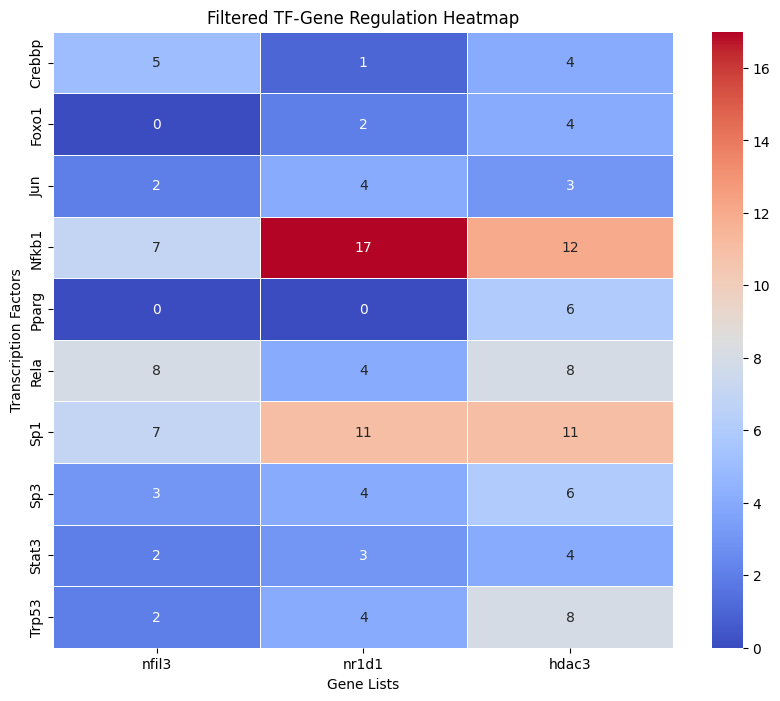

In [37]:
# Apply a threshold to filter TFs
threshold = 3  # Adjust this threshold based on the level of significance you want
tf_gene_filtered_df = tf_gene_df[(tf_gene_df > threshold).any(axis=1)]

# Display the filtered matrix
print(tf_gene_filtered_df.head())

# Plotting the filtered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tf_gene_filtered_df, cmap='coolwarm', linewidths=0.5, annot=True, fmt="d")
plt.title(' TF-Gene Regulation Heatmap')
plt.xlabel('Gene Lists')
plt.ylabel('Transcription Factors')
plt.show()

In [43]:
tf_gene_df

,nfil3,nr1d1,hdac3
Ar,1,0,0
Ascl1,1,1,0
Ash1l,0,1,0
Atf1,0,1,0
Atf2,1,1,0
...,...,...,...
Zbtb16,0,0,1
Zbtb33,1,0,0
Zeb1,0,1,0
Zfp64,1,0,0


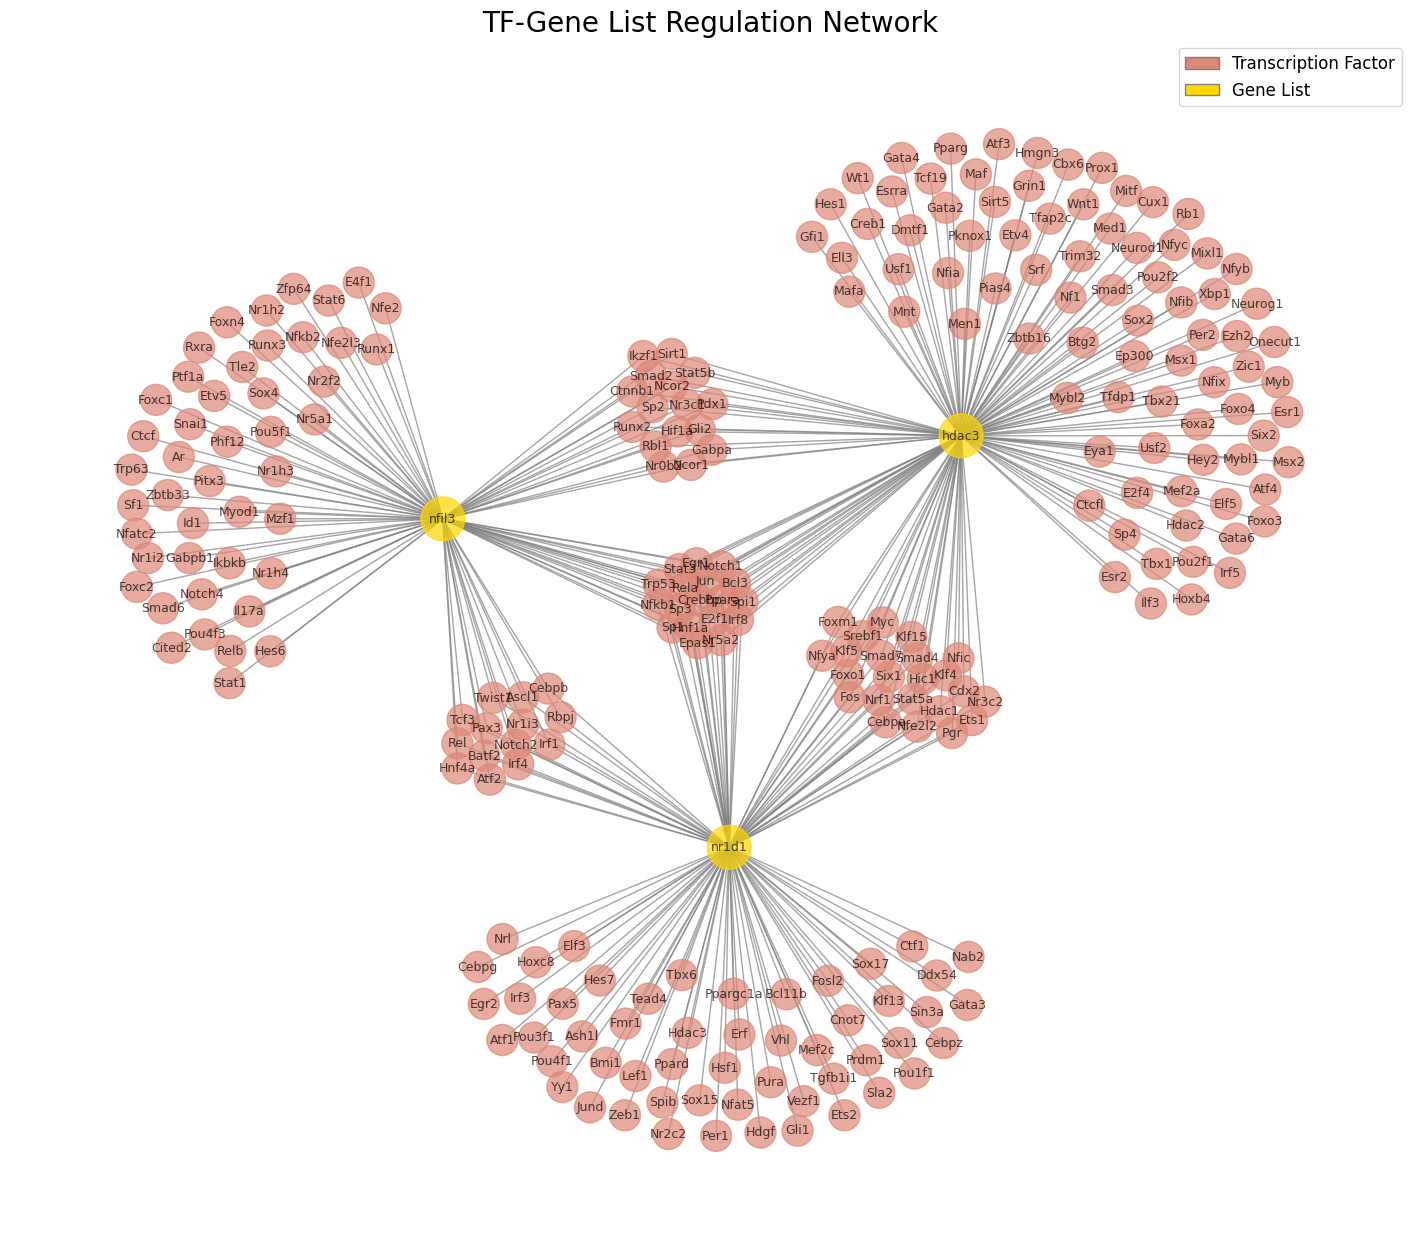

In [57]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming tf_gene_df is already loaded as shown in the image
# tf_gene_df = pd.DataFrame(...)

# Create the graph
G = nx.Graph()

# Add nodes for each TF and gene list
for tf in tf_gene_df.index:
    G.add_node(tf, type='TF')

for gene_list in tf_gene_df.columns:
    G.add_node(gene_list, type='GeneList')

# Add edges based on the DataFrame values
for tf in tf_gene_df.index:
    for gene_list in tf_gene_df.columns:
        if tf_gene_df.at[tf, gene_list] > 0:
            G.add_edge(tf, gene_list)

# Set node colors and sizes
node_colors = []
node_sizes = []
for node in G.nodes:
    if G.nodes[node]['type'] == 'TF':
        node_colors.append('#D87')  # Color for TF nodes
        node_sizes.append(500)      # Size for TF nodes
    else:
        node_colors.append('#FFD700')  # Color for gene list nodes
        node_sizes.append(1000)        # Larger size for gene list nodes

# Draw the network
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
nx.draw(G, pos, node_color=node_colors, with_labels=True, font_size=9, node_size=node_sizes, edge_color='gray', alpha=0.7)

# Add legend
legend_elements = [
    Patch(facecolor='#D87', edgecolor='gray', label='Transcription Factor'),
    Patch(facecolor='#FFD700', edgecolor='gray', label='Gene List')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize='large')

plt.title('TF-Gene List Regulation Network', fontsize=20)
plt.show()


Detailed Explanation:
Rows: Represent transcription factors (TFs).
Columns: Represent gene lists or conditions (e.g., nfil3, nr1d1, hdac3).
Values: Represent the number of genes in each gene list that are regulated by the corresponding TF.
To make sure this is clear, let's walk through the process with an example:

Load the Data:

The TRRUST database is loaded to map TFs to their target genes.
Gene lists for different conditions (e.g., nfil3, nr1d1, hdac3) are loaded.
Mapping TFs to Genes:

For each gene in the gene lists, the script identifies which TFs regulate them using the TRRUST database.
Creating the Regulation Matrix:

The matrix is built where each cell value is the count of genes in the gene list that are regulated by the TF.

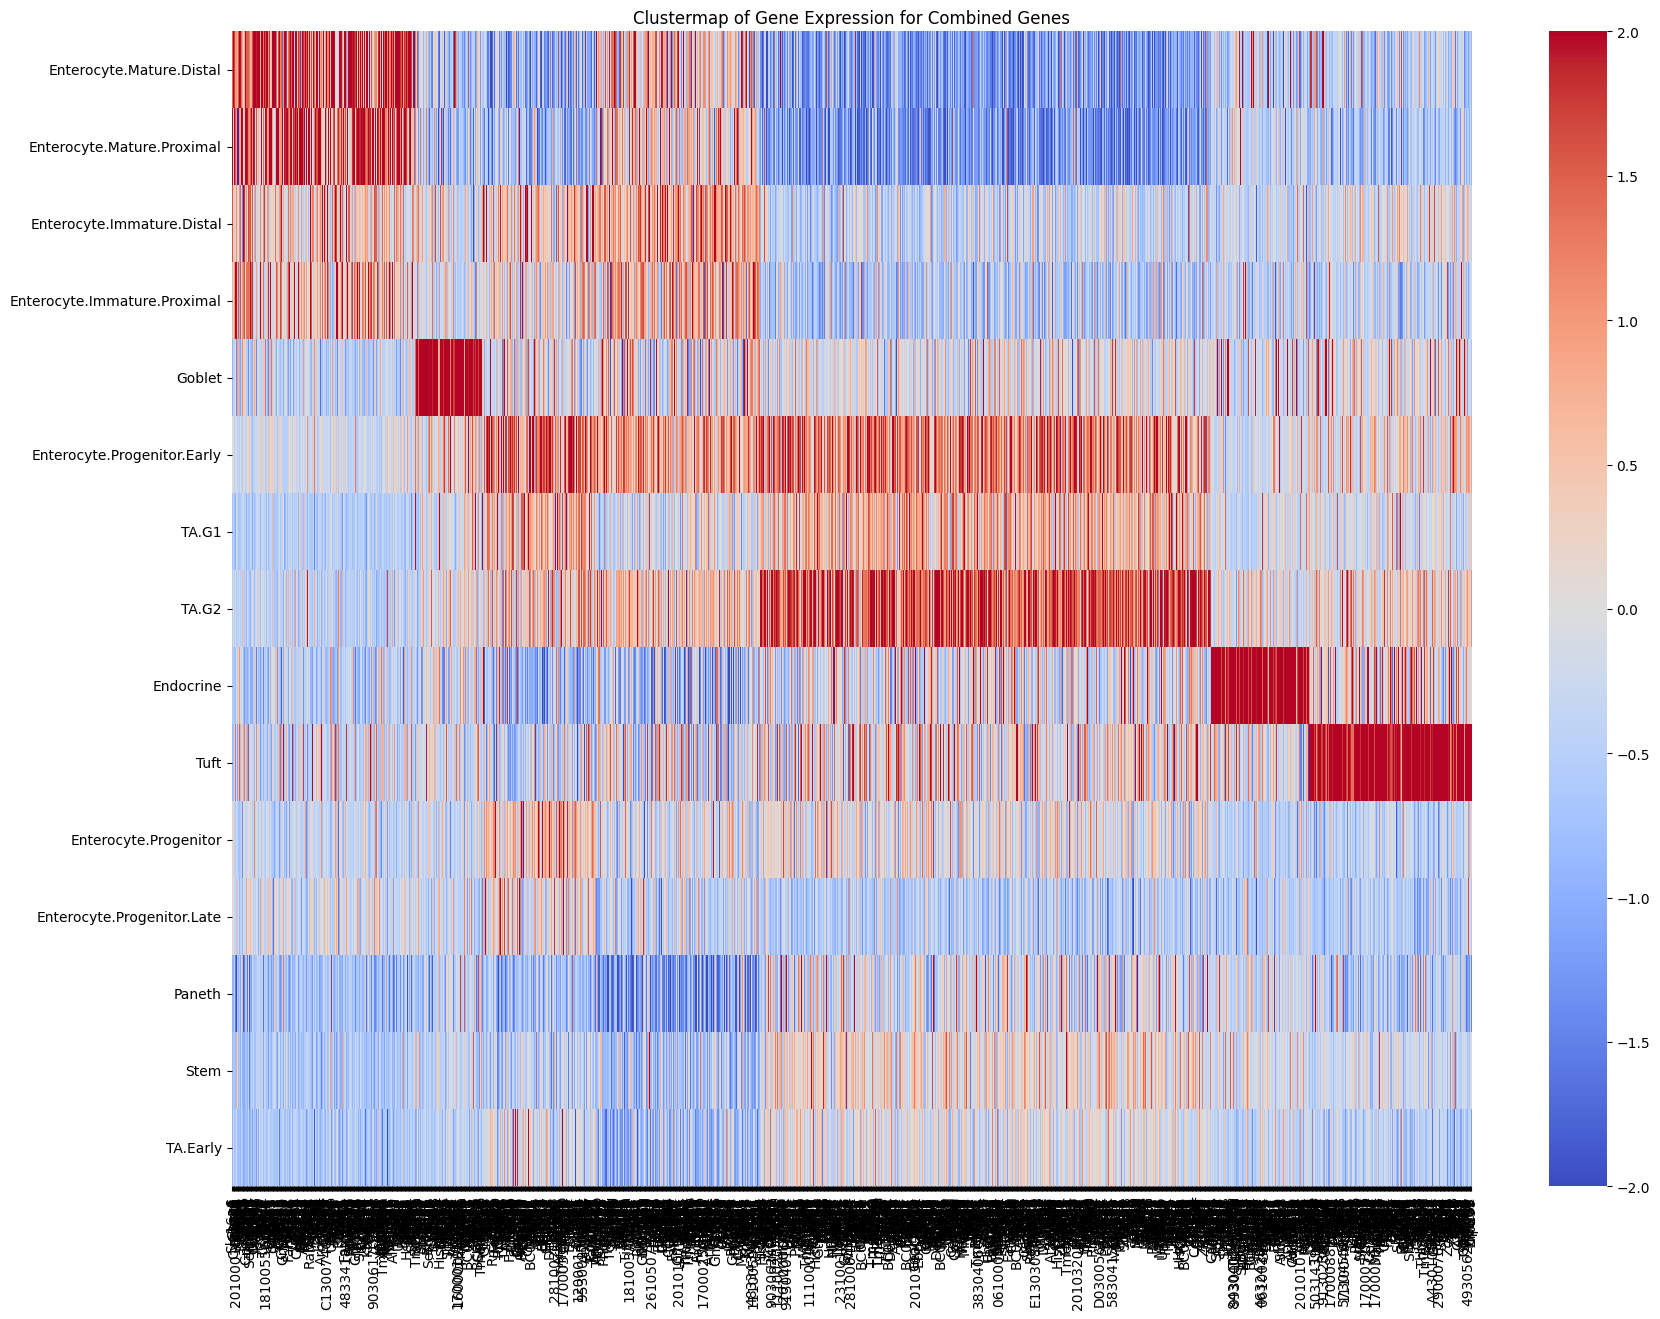

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster

# Load the gene lists
nfil3_genes = pd.read_csv('nfil3_uniq_ID.txt', header=None)[0].tolist()
nr1d1_genes = pd.read_csv('nr1d1_uniq_ID.txt', header=None)[0].tolist()
hdac3_genes = pd.read_csv('hdac3_uniq_ID.txt', header=None)[0].tolist()

# Combine all unique genes
combined_genes = list(set(nfil3_genes + nr1d1_genes + hdac3_genes))

# Load the data
data = pd.read_csv('atlas_mean.txt', sep='\t', index_col=0)

# Filter the data to include only the combined genes that are present in the data
valid_genes = [gene for gene in combined_genes if gene in data.index]
filtered_data = data.loc[valid_genes]

# Transpose the data: now genes are columns and cell types are rows
filtered_data = filtered_data.T

# Data normalization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(filtered_data)

# Convert back to dataframe for easier handling
normalized_df = pd.DataFrame(normalized_data, index=filtered_data.index, columns=filtered_data.columns)

# Hierarchical clustering for genes and cell types
gene_Z = linkage(normalized_df.T, method='ward', metric='euclidean')  # Cluster genes
cell_type_Z = linkage(normalized_df, method='ward', metric='euclidean')  # Cluster cell types

# Form flat clusters with a max number of clusters set to 7
gene_clusters = fcluster(gene_Z, t=7, criterion='maxclust')
cell_type_clusters = fcluster(cell_type_Z, t=7, criterion='maxclust')

# Create dictionaries to store the clusters
gene_clusters_dict = {i: [] for i in range(1, 8)}
cell_type_clusters_dict = {i: [] for i in range(1, 8)}

# Assign genes to clusters
for i, gene in enumerate(normalized_df.columns):
    gene_clusters_dict[gene_clusters[i]].append(gene)

# Assign cell types to clusters
for i, cell_type in enumerate(normalized_df.index):
    cell_type_clusters_dict[cell_type_clusters[i]].append(cell_type)

# Merge Cluster 6 into Cluster 1 and remove Cluster 6
merged_cell_types_dict = {1: cell_type_clusters_dict[1] + cell_type_clusters_dict[6]}
# Keep other clusters except Cluster 6
for cluster_id in range(2, 8):
    if cluster_id != 6:
        merged_cell_types_dict[cluster_id] = cell_type_clusters_dict[cluster_id]

# Define the new order: Cluster 1 (with merged Cluster 6), followed by Cluster 7, then the rest
new_cell_type_order = [1, 7] + [cluster_id for cluster_id in range(2, 8) if cluster_id not in [1, 6, 7]]

# Generate sorted indices based on the new cluster order
sorted_cell_type_indices = [cell_type for cluster_id in new_cell_type_order for cell_type in merged_cell_types_dict[cluster_id]]

# Sort the gene clusters
sorted_gene_indices = [gene for cluster_id in sorted(gene_clusters_dict.keys()) for gene in gene_clusters_dict[cluster_id]]

# Reorder the dataframe
sorted_df = normalized_df.loc[sorted_cell_type_indices, sorted_gene_indices]

# Plot the clustermap with sorted clusters
plt.figure(figsize=(20, 15))
sns.heatmap(sorted_df, cmap='coolwarm', xticklabels=True, yticklabels=True, vmin=-2, vmax=2)
plt.title('Clustermap of Gene Expression for Combined Genes')
plt.show()


# Save each gene cluster to a CSV file
for cluster_id, genes in gene_clusters_dict.items():
    cluster_df = data.loc[genes].T
    cluster_df.to_csv(f'gene_cluster_{cluster_id}.csv', index=False)


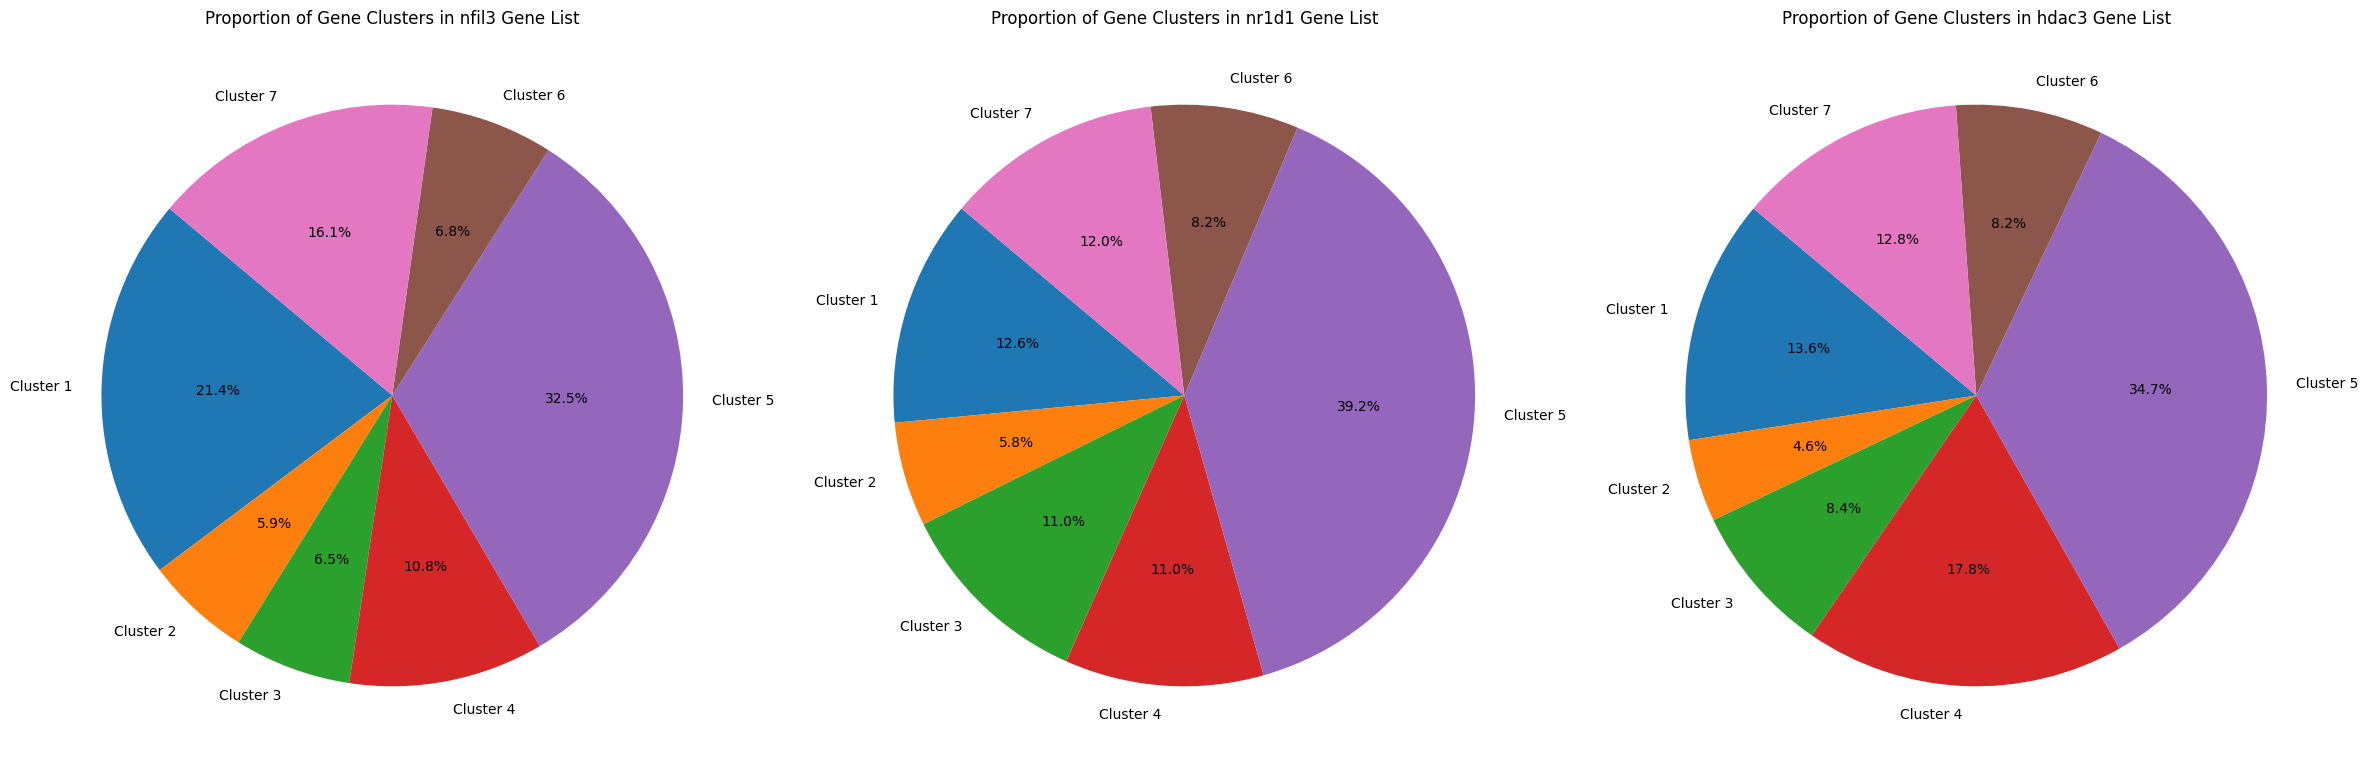

In [52]:
# Load the cluster CSV files
cluster_data = {}
for i in range(1, 8):
    cluster_data[i] = pd.read_csv(f'gene_cluster_{i}.csv')

# Load the gene lists for each unique ID group
nfil3_genes = pd.read_csv('nfil3_uniq_ID.txt', header=None)[0].tolist()
nr1d1_genes = pd.read_csv('nr1d1_uniq_ID.txt', header=None)[0].tolist()
hdac3_genes = pd.read_csv('hdac3_uniq_ID.txt', header=None)[0].tolist()

# Define a function to calculate and plot the pie chart for each gene list in a single row
def plot_pie_charts_for_gene_lists(gene_lists, cluster_data, titles):
    fig, axes = plt.subplots(1, len(gene_lists), figsize=(len(gene_lists) * 8, 8))

    for ax, gene_list, title in zip(axes, gene_lists, titles):
        # Count the number of genes in each cluster for the given gene list
        cluster_counts = [len(set(gene_list).intersection(cluster_data[i].columns)) for i in range(1, 8)]
        total_genes = sum(cluster_counts)
        cluster_proportions = [count / total_genes for count in cluster_counts]

        # Labels for the pie chart
        labels = [f'Cluster {i}' for i in range(1, 8)]

        # Plotting the pie chart
        ax.pie(cluster_proportions, labels=labels, autopct='%1.1f%%', startangle=140)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Plot pie charts for each gene list in a single row
plot_pie_charts_for_gene_lists(
    [nfil3_genes, nr1d1_genes, hdac3_genes],
    cluster_data,
    ['Proportion of Gene Clusters in nfil3 Gene List', 'Proportion of Gene Clusters in nr1d1 Gene List', 'Proportion of Gene Clusters in hdac3 Gene List']
)


